# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor

### Загрузка данных

In [2]:
df = pd.read_csv("/datasets/autos.csv")

In [3]:
df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Найдем пропуски значений в таблице.

In [5]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Видно, что пропусков в таблице много. Простое удаление пустых значений не подойдет, т.к. может сильно сказаться на результатах обучения модели. 
В таблице есть лишние столбцы, которые не имеют для обучения никакой ценности, а только лишь замедляют обучение модели.

### Обработка данных

**Удалим лишние столбцы.**

In [6]:
new_df = df.drop(["DateCrawled","DateCreated","LastSeen", "RegistrationMonth","PostalCode", "NumberOfPictures"],axis = 1)
new_df.tail()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no
354368,3400,wagon,2002,manual,100,golf,150000,gasoline,volkswagen,NaN


Заменим пропуски на наиболее часто встречающиеся с помощью mode()(так как это все категорийные признаки).

In [7]:
new_df["VehicleType"] = new_df["VehicleType"].fillna(new_df["VehicleType"].mode().values[0])
new_df["Gearbox"] = new_df["Gearbox"].fillna(new_df["Gearbox"].mode().values[0])
new_df["Model"] = new_df["Model"].fillna(new_df["Model"].mode().values[0])
new_df["FuelType"] = new_df["FuelType"].fillna(new_df["FuelType"].mode().values[0])
new_df["NotRepaired"] = new_df["NotRepaired"].fillna("no")

**Посмотрим распределение значений регистрации автомобиля по годам.**

In [8]:
new_df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Удалим аномальные значения года регистрации автомобиля. На данный момент год регистрация не может быть больше 2021, а за наименьший возьмем 1980, т.к до этого года в нашей выборке незначительное количество автомобилей.

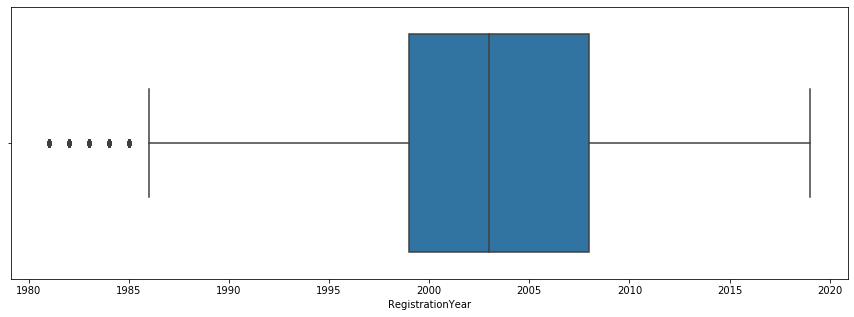

In [9]:
new_df=new_df.loc[(new_df['RegistrationYear']>1980)&(new_df['RegistrationYear']<2021)]

plt.figure(figsize=(15,5))
sns.boxplot(new_df["RegistrationYear"])

Text(0.5, 1.0, 'Распределения регистрации автомобиля по годам')

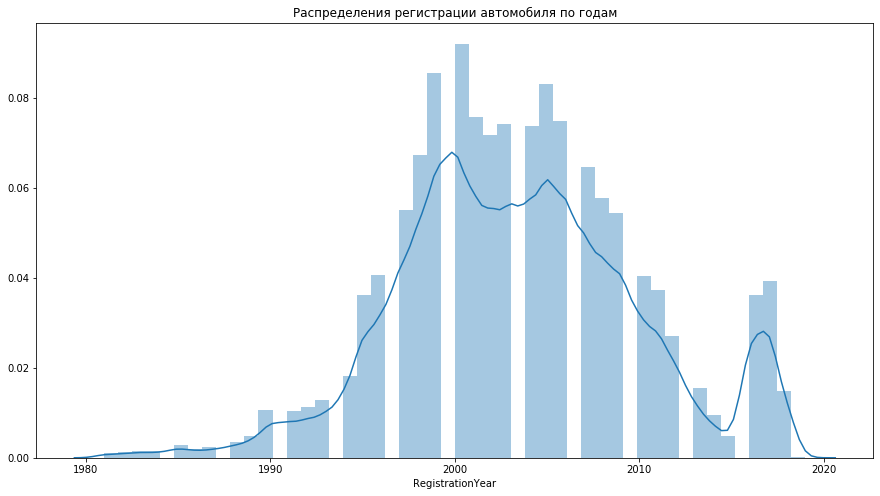

In [10]:
plt.figure(figsize=(15,8))
sns.distplot(new_df["RegistrationYear"])
plt.title('Распределения регистрации автомобиля по годам', fontsize=12)

**Посмотрим распределение значений мощности автомобиля.**

Чтобы исключить аномальные значения мощности автомобилей, возьмем значения в пределах от 50 до 1500.

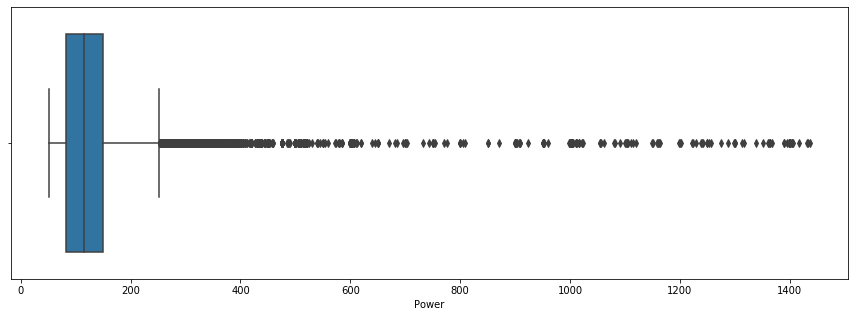

In [11]:
new_df=new_df.loc[(new_df['Power']>50)&(new_df['Power']<1500)]

plt.figure(figsize=(15,5))
sns.boxplot(new_df["Power"])

Text(0.5, 1.0, 'Распределение значений мощности автомобиля')

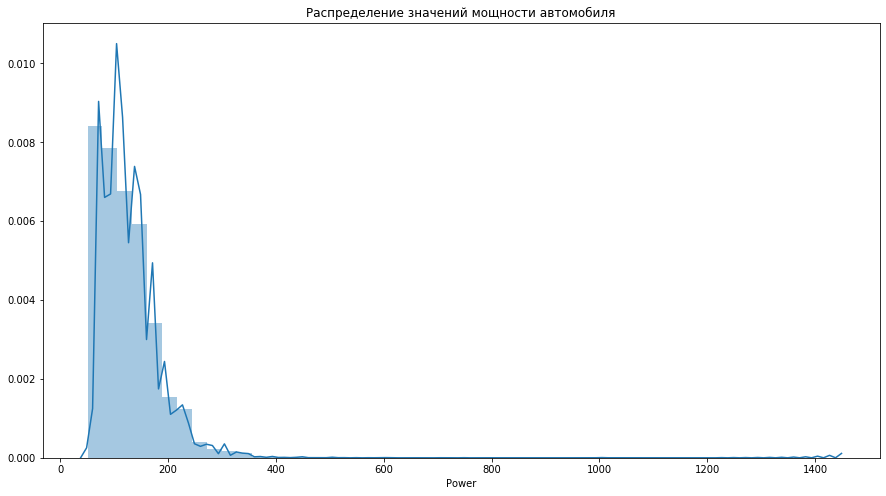

In [12]:
plt.figure(figsize=(15,8))
sns.distplot(new_df["Power"])
plt.title('Распределение значений мощности автомобиля', fontsize=12)

Удалим аномальные значения целевого признака исходя из значений первого квантиля.

Text(0.5, 1.0, 'Распределение значений стоимости автомобиля')

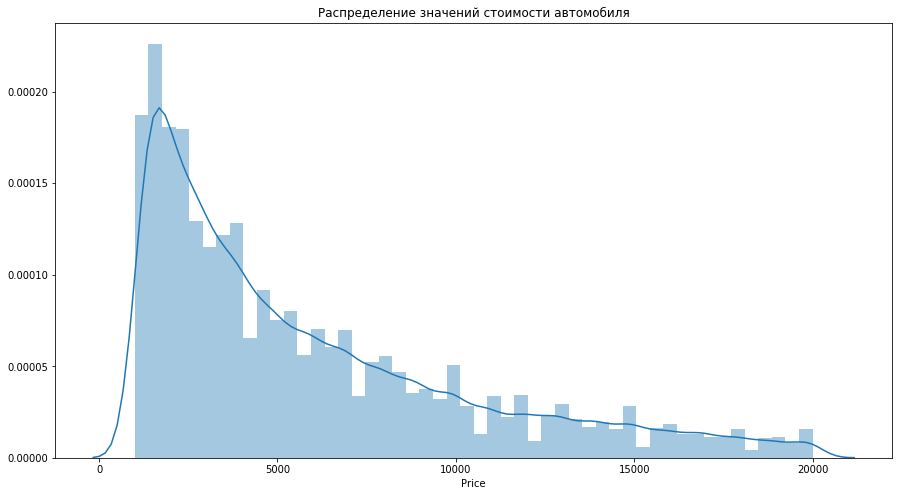

In [13]:
df_clear=new_df.loc[(new_df['Price']>1000)]

plt.figure(figsize=(15,8))
sns.distplot(df_clear["Price"])
plt.title('Распределение значений стоимости автомобиля', fontsize=12)

In [14]:
df_clear.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.469135,0.429502,-0.384564
RegistrationYear,0.469135,1.000000,-0.009075,-0.362277
Power,0.429502,-0.009075,1.000000,0.156679
Kilometer,-0.384564,-0.362277,0.156679,1.000000


## Обучение моделей

### Разделим данные на выборки

In [15]:
df_clear.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,golf,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [16]:
df_clear['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'convertible', 'bus', 'sedan', 'wagon',
       'other'], dtype=object)

In [17]:
y=new_df['Price']
X=new_df.drop(['Price'],axis=1)

In [18]:
cat_features=["VehicleType","Gearbox","Model","FuelType", "Brand","NotRepaired"]
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [19]:
data = train_test_split(X, y, train_size=0.8, random_state=30)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(data=X_train, label=y_train, cat_features=["VehicleType","Gearbox","Model","FuelType", "Brand","NotRepaired"])
validation_pool = Pool(data=X_validation, label=y_validation, cat_features=["VehicleType","Gearbox","Model","FuelType", "Brand","NotRepaired"])

### Подбор параметров для CatBoost

Попробуем подобрать оптимальные параметры для CatBoost, используя GridSearchCV.

In [20]:
CBC = CatBoostRegressor(iterations=200)

In [21]:
grid = {
    'depth' : [5,6,7,8,9,10], 
    'learning_rate' : [0.1,0.3,0.4]
}

In [ ]:
result = CBC.grid_search(grid, train_pool, verbose=True)

### Время обучения разных моделей по заданым параметрам.

**CatBoost**

In [37]:
%%time
model_CBR = CatBoostRegressor(
    depth=10,
    iterations=200,
    learning_rate=0.3,
    early_stopping_rounds=20
)

model_CBR.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=True
)

print('Model is fitted: {}'.format(model_CBR.is_fitted()))
print('Model params:\n{}'.format(model_CBR.get_params()))

0:	learn: 3634.8977603	test: 3653.1831104	best: 3653.1831104 (0)	total: 813ms	remaining: 2m 41s
1:	learn: 3002.6059888	test: 3022.8029759	best: 3022.8029759 (1)	total: 1.71s	remaining: 2m 49s
2:	learn: 2610.5712082	test: 2631.0674241	best: 2631.0674241 (2)	total: 2.61s	remaining: 2m 51s
3:	learn: 2347.7117635	test: 2370.5587753	best: 2370.5587753 (3)	total: 3.5s	remaining: 2m 51s
4:	learn: 2194.7625220	test: 2219.2075600	best: 2219.2075600 (4)	total: 4.22s	remaining: 2m 44s
5:	learn: 2093.6963490	test: 2114.8140213	best: 2114.8140213 (5)	total: 5.1s	remaining: 2m 45s
6:	learn: 2028.0588486	test: 2049.2635838	best: 2049.2635838 (6)	total: 5.81s	remaining: 2m 40s
7:	learn: 1976.1245348	test: 1995.6432051	best: 1995.6432051 (7)	total: 6.61s	remaining: 2m 38s
8:	learn: 1938.4007709	test: 1956.3042992	best: 1956.3042992 (8)	total: 7.41s	remaining: 2m 37s
9:	learn: 1916.0554257	test: 1934.8688914	best: 1934.8688914 (9)	total: 8.3s	remaining: 2m 37s
10:	learn: 1898.1498774	test: 1916.9127443	

**RandomForest**

In [23]:
df_ohe = pd.get_dummies(df_clear)

In [24]:
trainX,testX,trainY,testY = train_test_split(df_ohe.drop("Price",axis = 1),
                                             df_ohe["Price"],
                                             train_size=0.8, random_state=30
                                            )

In [41]:
%%time
RF = RandomForestRegressor(criterion = "mse", n_estimators = 200)
RF.fit(trainX,trainY)

CPU times: user 12min 15s, sys: 0 ns, total: 12min 15s
Wall time: 12min 22s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

**LightGBM**

In [45]:
%%time
modelLight = LGBMRegressor(
    depth = 10,
    n_estimators = 200, 
    learning_rate = 0.3, 
    random_state = 42, 
)

modelLight.fit(
    trainX, trainY, 
    eval_set = (testX, testY), 
    eval_metric = 'RMSE', 
    verbose = 10
)

[10]	valid_0's rmse: 1984.29	valid_0's l2: 3.9374e+06
[20]	valid_0's rmse: 1834.92	valid_0's l2: 3.36694e+06
[30]	valid_0's rmse: 1785.85	valid_0's l2: 3.18928e+06
[40]	valid_0's rmse: 1753.77	valid_0's l2: 3.0757e+06
[50]	valid_0's rmse: 1732.44	valid_0's l2: 3.00136e+06
[60]	valid_0's rmse: 1715.29	valid_0's l2: 2.94223e+06
[70]	valid_0's rmse: 1702.67	valid_0's l2: 2.8991e+06
[80]	valid_0's rmse: 1691.73	valid_0's l2: 2.86194e+06
[90]	valid_0's rmse: 1682.29	valid_0's l2: 2.83009e+06
[100]	valid_0's rmse: 1673.04	valid_0's l2: 2.79907e+06
[110]	valid_0's rmse: 1665.48	valid_0's l2: 2.77383e+06
[120]	valid_0's rmse: 1658.8	valid_0's l2: 2.75161e+06
[130]	valid_0's rmse: 1653.08	valid_0's l2: 2.73269e+06
[140]	valid_0's rmse: 1648.84	valid_0's l2: 2.71868e+06
[150]	valid_0's rmse: 1644.06	valid_0's l2: 2.70292e+06
[160]	valid_0's rmse: 1642.24	valid_0's l2: 2.69694e+06
[170]	valid_0's rmse: 1638.34	valid_0's l2: 2.68415e+06
[180]	valid_0's rmse: 1634.36	valid_0's l2: 2.67114e+06
[190]

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=10, importance_type='split', learning_rate=0.3,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [34]:
%%time

for X in [X_train, X_validation]:
    for cat in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
        X[cat] = X[cat].astype('category')
    
modelLight = LGBMRegressor(
    depth = 5,
    n_estimators = 50, 
    learning_rate = 0.3, 
    random_state = 42, 
)

modelLight.fit(
    X_train, y_train,
    verbose = 10
)

mean_squared_error(y_validation, modelLight.predict(X_validation))**(.5)

CPU times: user 25.2 s, sys: 140 ms, total: 25.3 s
Wall time: 25.7 s


1712.8663013170371

### Время предсказания разных моделей

**CatBoost**

In [47]:
%%time 
cat_pred = model_CBR.predict(X_validation)
print("RMSE CatBoost: ", mean_squared_error(y_validation, cat_pred)**(.5))

RMSE CatBoost:  1664.1563694240124
CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 279 ms


**RandomForest**

In [48]:
%%time
RF_pred = RF.predict(testX)
print("RMSE RandomForest:",mean_squared_error(testY, RF_pred)**(.5))

RMSE RandomForest: 1639.096202494774
CPU times: user 4.89 s, sys: 0 ns, total: 4.89 s
Wall time: 5.09 s


**LightGBM**

In [45]:
%%time
Light_pred = modelLight.predict(testX)
print("RMSE RandomForest:",mean_squared_error(testY, Light_pred)**(.5))

RMSE RandomForest: 1646.3048187640022
CPU times: user 675 ms, sys: 0 ns, total: 675 ms
Wall time: 672 ms


## Анализ моделей

Обучили 3 модели с одинаковыми гипепараметрами. Таким образом CatBoost и LightGBM оба показали очень неплохие результаты , где у каждой есть превохсодства над другой моделью. Обе показали вполне неплохие результыт RMSE. Однако показатели времени на обучение очень сильно отличаются в пользу LightGBM. RandomForest же обучался в разы медленей, но показатель RMSE тоже хороший

Таким образом для данного проекта лучшей моделью будет являться LightGBM с глубиной в 10 , так как время на обучение намного мешь по сравнению с остальными, а показатель RMSE примерно на одном уровне с остальными